In [1]:
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras as keras
from IPython import display
from sklearn import metrics

In [2]:
data = pd.read_csv("../nba-movement-data/data/shots/shooter_and_defender_per_shot_ranked.csv", sep=",")

data.fillna(value={'defender_embedding_index': 443}, inplace=True)
print(data.shape)
data.head(5)

(27321, 14)


,player_id,game_id,event_id,game_clock,shot_clock,x_loc,y_loc,player_id_closest_defender,closest_distance_from_shooter,distance_from_basket,shot_made_flag,recorded_shot_distance,shooter_embedding_index,defender_embedding_index
0,201143,21500001,228,1346.48,10.44,5.90704,38.78493,203083,4.823530,14.088122,1,13,98,255.0
1,202704,21500001,437,2575.29,13.97,19.94944,21.56599,200794,0.885241,17.293812,0,1,233,94.0
2,2594,21500001,477,2721.36,11.19,22.62340,11.06127,203484,2.368097,24.070023,1,20,46,306.0
3,2594,21500001,507,2831.96,17.99,22.47487,13.84307,202704,5.118656,22.444323,0,21,46,233.0
4,203076,21500003,504,2421.86,8.87,24.98951,35.88171,202691,2.629288,24.534673,1,16,248,222.0


In [3]:
data_grouped = data.groupby(['player_id']).size().reset_index(name='count')
data_grouped = data_grouped[data_grouped['count'] > 2]

data = data.merge(data_grouped, on=['player_id'], how='inner')

print(data.shape)
data.head(5)

(27297, 15)


,player_id,game_id,event_id,game_clock,shot_clock,x_loc,y_loc,player_id_closest_defender,closest_distance_from_shooter,distance_from_basket,shot_made_flag,recorded_shot_distance,shooter_embedding_index,defender_embedding_index,count
0,201143,21500001,228,1346.48,10.44,5.90704,38.78493,203083,4.823530,14.088122,1,13,98,255.0,204
1,201143,21500389,23,155.78,22.63,34.75976,28.39524,101161,7.724437,31.940727,1,1,98,79.0,204
2,201143,21500117,128,684.09,11.85,28.63058,34.59180,201962,11.755243,27.366572,1,24,98,172.0,204
3,201143,21500639,9,98.68,14.22,17.88401,27.73281,203943,5.145146,15.132812,0,9,98,364.0,204
4,201143,21500117,185,1071.38,12.05,22.85049,28.88055,201583,8.837067,20.226236,1,18,98,139.0,204


/home/ax/miniconda3/envs/tf1-x/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


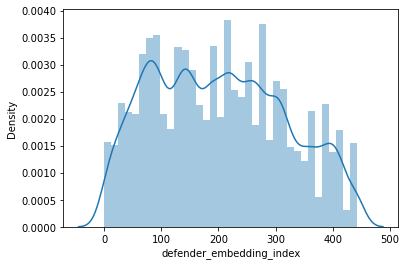

In [4]:
sns.distplot(data.defender_embedding_index);

In [5]:
terms_embedding_column = tf.feature_column.embedding_column('player_id', dimension=5)
feature_columns = ['shooter_embedding_index', 'x_loc', 'y_loc','recorded_shot_distance', 'closest_distance_from_shooter', 'defender_embedding_index']

player_size = 443 + 1
player_size

444

In [6]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, LeakyReLU, add, Concatenate

input1 = keras.layers.Input(shape=(1,), name='shooter_index')
input2 = Input(shape=(4,))
input3 = Input(shape=(1,), name='defender_index')
input4 = Input(shape=(1,))
input5 = Input(shape=(1,)) 

off_emb = Embedding(input_dim=player_size, output_dim=50,input_length = 1, name='embedding_offense')(input1)
off_emb = Flatten()(off_emb)

def_emb = Embedding(input_dim=player_size, output_dim=50,input_length = 1, name='embedding_defense')(input3)
def_emb = Flatten()(def_emb)

off_emb_constant = Dense(50, activation=LeakyReLU(alpha=0.1), name='average_off')(input5)
def_emb_constant = Dense(50, activation=LeakyReLU(alpha=0.1), name='average_def')(input5)

off_emb_add = add([off_emb_constant, off_emb], name='add_off') 
def_emb_add = add([def_emb_constant, def_emb], name='add_def')

off_concat = Concatenate(axis=1, name='concat_offense')([off_emb_add, input2]) 

def_concat = Concatenate(axis=1, name='concat_defense')([def_emb_add, input4]) 

off_relu = Dense(20, activation='relu')(off_concat)
def_relu = Dense(20, activation='relu')(def_concat)


full_concat = Concatenate(axis=1)([off_relu, def_relu])

w = Dense(40, activation=LeakyReLU(alpha=0.1))(full_concat)
x = Dense(20, activation=LeakyReLU(alpha=0.1))(w)
y = Dense(20, activation=LeakyReLU(alpha=0.1))(x)
z = Dense(5, activation=LeakyReLU(alpha=0.1))(y)
output = Dense(1, activation='sigmoid')(z)

model = tf.keras.Model(inputs=[input1, input2, input3, input4, input5], outputs=output)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
shooter_index (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
defender_index (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
_____________________________________________________________________________________________

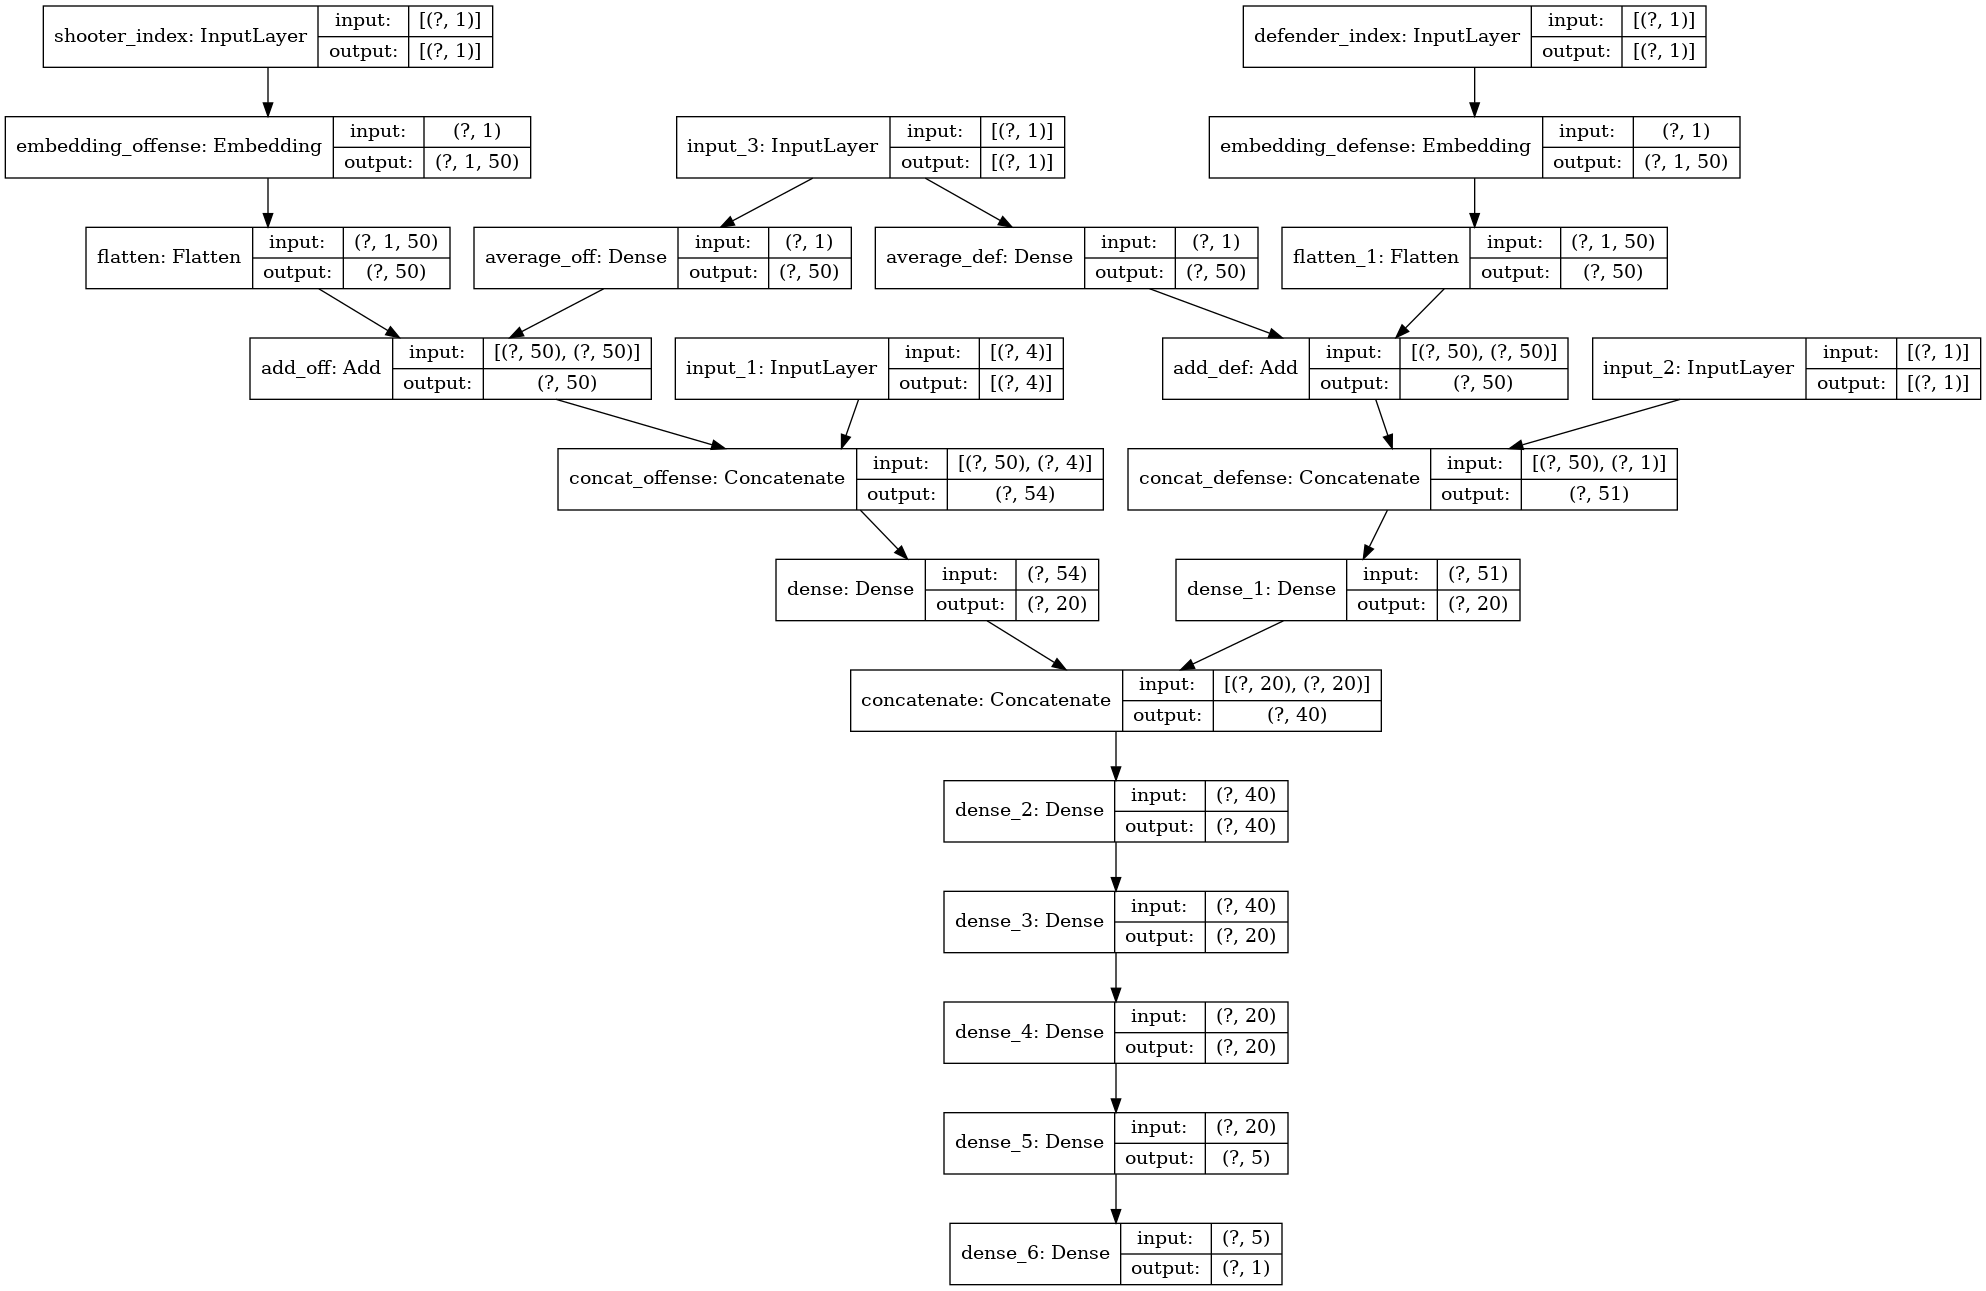

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
data.head()


,player_id,game_id,event_id,game_clock,shot_clock,x_loc,y_loc,player_id_closest_defender,closest_distance_from_shooter,distance_from_basket,shot_made_flag,recorded_shot_distance,shooter_embedding_index,defender_embedding_index,count
0,201143,21500001,228,1346.48,10.44,5.90704,38.78493,203083,4.823530,14.088122,1,13,98,255.0,204
1,201143,21500389,23,155.78,22.63,34.75976,28.39524,101161,7.724437,31.940727,1,1,98,79.0,204
2,201143,21500117,128,684.09,11.85,28.63058,34.59180,201962,11.755243,27.366572,1,24,98,172.0,204
3,201143,21500639,9,98.68,14.22,17.88401,27.73281,203943,5.145146,15.132812,0,9,98,364.0,204
4,201143,21500117,185,1071.38,12.05,22.85049,28.88055,201583,8.837067,20.226236,1,18,98,139.0,204


In [10]:
from sklearn.model_selection import train_test_split

X_shooter = data[['shooter_embedding_index']]
X_off_rest = data[['x_loc', 'y_loc', 'recorded_shot_distance', 'closest_distance_from_shooter']]
X_defender = data[['defender_embedding_index']]
X_defender_rest = data[['closest_distance_from_shooter']]
X_ones = pd.DataFrame(np.ones(data.shape[0]))
y = data[['shot_made_flag']]

print(X_shooter.shape)
print(X_off_rest.shape)
print(X_defender.shape)
print(X_defender_rest.shape)
print(X_ones.shape)
print(y.shape)

(27297, 1)
(27297, 4)
(27297, 1)
(27297, 1)
(27297, 1)
(27297, 1)


In [11]:
history = model.fit([X_shooter, X_off_rest, X_defender, X_defender_rest, X_ones],
                    y,
                    epochs=2000,
                    batch_size=2**15,
                    verbose=1)

===================] - 0s 0us/sample - loss: 0.2757 - acc: 0.8711 - auc: 0.9472
Epoch 1835/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.2849 - acc: 0.8649 - auc: 0.9526
Epoch 1836/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.2861 - acc: 0.8641 - auc: 0.9420
Epoch 1837/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.2952 - acc: 0.8589 - auc: 0.9489
Epoch 1838/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.2889 - acc: 0.8614 - auc: 0.9409
Epoch 1839/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.2849 - acc: 0.8660 - auc: 0.9524
Epoch 1840/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.2688 - acc: 0.8742 - auc: 0.9514
Epoch 1841/2000
27297/27297 [==============================] - 0s 0us/sample - loss: 0.2635 - acc: 0.8784 - auc: 0.9553
Epoch 1842/2000
27297/27297 [==============================] - 0s 0us/sample - l

In [12]:
offensive_weights = model.get_layer('embedding_offense').get_weights()[0]
print(offensive_weights.shape)

defensive_weights = model.get_layer('embedding_defense').get_weights()[0]
print(defensive_weights.shape)

(444, 50)
(444, 50)


In [13]:
filtered_data = data.groupby(['player_id', 'shooter_embedding_index']).size().reset_index(name='count')
filtered_data = filtered_data[filtered_data['count'] > 20]

filtered_offensive_weights = []
filtered_offensive_players = filtered_data['shooter_embedding_index'].tolist()

for idx, weight in enumerate(offensive_weights):
  if idx in filtered_offensive_players:
    filtered_offensive_weights.append(weight)
    
filtered_data = data.groupby(['defender_embedding_index']).size().reset_index(name='count')
filtered_data = filtered_data[filtered_data['count'] > 20]

filtered_defensive_weights = []
filtered_defensive_players = filtered_data['defender_embedding_index'].tolist()

for idx, weight in enumerate(defensive_weights):
  if idx in filtered_defensive_players:
    filtered_defensive_weights.append(weight)

print(len(filtered_offensive_weights))
print(len(filtered_offensive_players))
print(len(filtered_defensive_weights))
print(len(filtered_defensive_players))

306
306
324
324


In [14]:
player_data = pd.read_csv("../nba-movement-data/data/player/player_aggregates.csv", sep=",")
shooter_player_data = player_data[player_data['rank'].isin(filtered_offensive_players)]
defender_player_data = player_data[player_data['rank'].isin(filtered_defensive_players)]

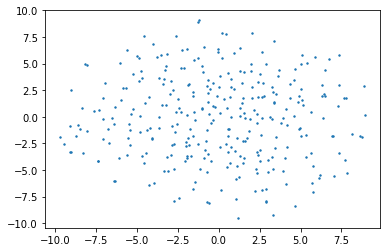

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
X_hat = tsne.fit_transform(filtered_offensive_weights)

plt.scatter(X_hat[:,0], X_hat[:,1], s = 2)

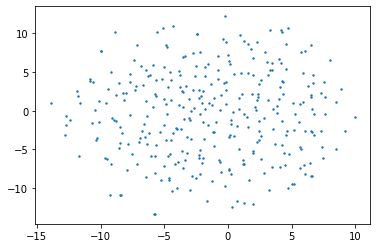

In [16]:
tsne = TSNE(n_components = 2)
X_hat = tsne.fit_transform(filtered_defensive_weights)

plt.scatter(X_hat[:,0], X_hat[:,1], s = 2)

In [34]:
from scipy.spatial import distance

def similar_players(player_name):
    off_index = filtered_offensive_players.index(int(shooter_player_data[shooter_player_data["PLAYER_NAME"] == player_name]["rank"]))
    def_index = filtered_defensive_players.index(int(defender_player_data[defender_player_data["PLAYER_NAME"] == player_name]["rank"]))

    off_distances = pd.DataFrame(filtered_offensive_weights).apply(lambda row: distance.euclidean(row, filtered_offensive_weights[off_index]), axis=1).sort_values()
    def_distances = pd.DataFrame(filtered_defensive_weights).apply(lambda row: distance.euclidean(row, filtered_defensive_weights[def_index]), axis=1).sort_values()

    off_sim_players = []
    def_sim_players = []

    for idx in range(1, 6):
        off_sim_players.append(shooter_player_data.iloc[off_distances.index[idx]]["PLAYER_NAME"])
        def_sim_players.append(defender_player_data.iloc[def_distances.index[idx]]["PLAYER_NAME"])

    print("5 Most Similar Offensive Players:\n", off_sim_players)

    print("5 Most Similar Defensive Players:\n", def_sim_players)

In [35]:
similar_players("Kobe Bryant")

5 Most Similar Offensive Players:
 ['Otto Porter Jr.', 'Al Horford', 'Avery Bradley', 'Garrett Temple', 'Jrue Holiday']
5 Most Similar Defensive Players:
 ['Serge Ibaka', 'Nikola Vucevic', 'Zaza Pachulia', 'Kristaps Porzingis', 'Garrett Temple']


In [36]:
similar_players("Tim Duncan")

5 Most Similar Offensive Players:
 ['Amir Johnson', 'Goran Dragic', 'DeAndre Jordan', 'Aron Baynes', 'Bradley Beal']
5 Most Similar Defensive Players:
 ['D.J. Augustin', 'Doug McDermott', 'Victor Oladipo', 'DeMarcus Cousins', "D'Angelo Russell"]


In [37]:
similar_players("Dwight Howard")

5 Most Similar Offensive Players:
 ["Kyle O'Quinn", 'Jon Leuer', 'Julius Randle', 'Enes Kanter', 'James Johnson']
5 Most Similar Defensive Players:
 ['Lou Amundson', 'Cameron Payne', 'Rodney Stuckey', 'Mike Scott', 'Paul Pierce']
